# LTI Systems

Let us consider a double integrator system:
$$
\dot{x}_1 = v_1, \\ 
\dot{x}_2 = v_2, \\ 
\dot{v}_1 = u_1, \\ 
\dot{v}_2 = u_2.
$$
The dynamics matrix $A_c$ and control input matrix $B_c$ are 
$$
A_c = \begin{bmatrix}
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
    0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 
\end{bmatrix}, \quad
B_c = \begin{bmatrix}
0 & 0 \\
0 & 0 \\
1 & 0 \\
0 & 1
\end{bmatrix}.
$$

In [1]:
import numpy as np
from quadprog import solve_qp
# Double integrator dynamics
dim_x = 4
dim_u = 2
Ac = np.array([[0, 0, 1, 0], 
               [0, 0, 0, 1], 
               [0, 0, 0, 0], 
               [0, 0, 0, 0]])
Bc = np.array([[0, 0], 
               [0, 0], 
               [1, 0], 
               [0, 1]])

assert Ac.shape == (dim_x, dim_x)
assert Bc.shape == (dim_x, dim_u)

# **Exact** Discretization of LTI Systems

The goal of exact discretization is to convert a continuous-time LTI system into its discrete-time equivalent with the exact same dynamics, assuming the input signal is held **constant (zero-order hold)** during each sampling interval.

### Continuous-Time LTI System
The continuous-time state-space representation is:
$$
\dot{x}(t) = A_c x(t) + B_c u(t), \quad y(t) = C_c x(t) + D_c u(t).
$$

We want to derive the equivalent discrete-time system:
$$
x_{k+1} = A_d x_k + B_d u_k, \quad y_k = C_d x_k + D_d u_k,
$$
where $x_k = x(kT)$ represents the sampled state vector at discrete time $k$, with sampling interval $T$.

### State Transition Over One Sampling Interval
The solution to the continuous-time state equation over the interval $[kT, (k+1)T]$ is:
$$
\begin{align}
x((k+1)T) &= e^{A_c T} x(kT) + \int_0^T e^{A_c (T-\tau)} B_c u(kT) \, d\tau, \\
          &= A_d  x(kT) + B_d u(kT).
\end{align}
$$
Here:
- $A_d = e^{A_c T}$:
  The exact state transition matrix for the discrete system.
- $B_d = \int_0^T e^{A_c (T - \tau)} B_c \, d\tau = \left(\int_0^T e^{A_c \tau^\prime} d\tau^\prime \right) B_c$:
  This accounts for the effect of the input $u_k$ over one sampling period under the assumption of zero-order hold.

### Computing the Matrices

One useful trick to compute the system matrices $A_d$ and $B_d$ for the discretized system is by utilizing the following property:
$$
e^{\begin{bmatrix}
A_c & B_c \\
0 & 0
\end{bmatrix} T } = 
\begin{bmatrix}
A_d & B_d \\
0 & I
\end{bmatrix}.
$$

In [2]:
# Discretize the dynamics
dt = 0.1
# Trick to compute the matrix exponential
from scipy.linalg import expm
ABc = np.zeros((dim_x + dim_u, dim_x + dim_u))
ABc[:dim_x, :dim_x] = Ac
ABc[:dim_x, dim_x:] = Bc
expm_ABc = expm(ABc*dt)
Ad = expm_ABc[:dim_x, :dim_x]
Bd = expm_ABc[:dim_x, dim_x:]

print(f"Ad:\n{Ad}")
print(f"Bd:\n{Bd}")

Ad:
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]
Bd:
[[0.005 0.   ]
 [0.    0.005]
 [0.1   0.   ]
 [0.    0.1  ]]


# An Example of Linear MPC

The linear MPC problem can be formulated as follows:
$$
\begin{aligned}
    \min_{\bar{x}, \bar{u}} \quad & \sum_k^{N-1} \frac{1}{2} x_k^\top Q x_k + \frac{1}{2} u_k^\top R u_k + \frac{1}{2} u_N^\top \red{P} u_N \\
    \text{s.t.} \quad & x_{k+1} = A x_k + B u_k, \; k = 0, \dots, N-1, \\
    & u_{\text{lb}} \leq u_k \leq u_{\text{ub}}, \quad\quad k = 0, \dots, N-1.
\end{aligned}
$$
Here:
- $Q$, $R$, $\red{P}$: cost matrices. 
- $\bar{x} := (x_0, \dots, x_{N})$: state sequence.
- $\bar{u} := (u_0, \dots, u_{N-1})$: control sequence.
- $N$: prediction horizon.
- $u_{\text{lb}}$ and $u_{\text{ub}}$: lower and upper bounds.

## Sparse Formulation
- Both $\bar{x}$ and $\bar{u}$ are decision variables.
- Treat the dynamics as equaltiy constraints.

In [3]:
import cvxpy as cp  # https://www.cvxpy.org/

def solve_mpc_sparse(Ad, Bd, Q, R, P, x0, N, u_lb, u_ub):
    dim_x = Ad.shape[0]
    dim_u = Bd.shape[1]

    # Define the optimization variables
    x_bar = cp.Variable((N+1, dim_x))
    u_bar = cp.Variable((N, dim_u))

    # Cost & constraints
    cost = 0.
    constraints = []
    constraints += [x_bar[0, :] == x0]
    for t in range(N):
        constraints += [x_bar[t+1, :] == Ad @ x_bar[t, :] + Bd @ u_bar[t, :]]
        constraints += [u_lb <= u_bar[t, :], u_bar[t, :] <= u_ub]

        cost += 0.5 * cp.quad_form(x_bar[t, :], Q) + 0.5 * cp.quad_form(u_bar[t, :], R)
    
    cost += 0.5 * cp.quad_form(x_bar[N, :], P)
    
    # Solve the problem
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    
    return x_bar.value, u_bar.value

# Dense Formulation
- $\bar{u}$ is the only decision variable.

Our next step is to replace the states shown up in the cost function with the control sequence. Let us first roll out the system.
$$
\begin{aligned}
x_1 &= A x_0 + B u_0 \\
x_2 &= A x_1 + B u_1 = A (A x_0 + B u_0) + B u_1 = A^2 x_0 + A B u_0 + B u_1 \\
x_3 &= A x_2 + B u_2 = A (A^2 x_0 + A B u_0 + B u_1) + B u_2 = A^3 x_0 + A^2 B u_0 + A B u_1 + B u_2 \\
&\vdots \\
x_N &= A^N x_0 + A^{N-1} B u_0 + A^{N-2} B u_1 + \cdots + B u_{N-1}
\end{aligned}
$$


Write the predicted states in matrix form:
$$
\begin{bmatrix}
x_0 \\ x_1 \\ \vdots \\ x_N
\end{bmatrix} = T x_0 + S 
\begin{bmatrix}
u_0 \\ u_1 \\ \vdots \\ u_{N-1}
\end{bmatrix},
$$
where
$$
T := \begin{bmatrix}
I \\ A \\ A^2 \\ \vdots \\ A^N \\
\end{bmatrix}, \quad
S := \begin{bmatrix}
0 & 0 & 0 & \cdots & 0 \\
B & 0 & 0 & \cdots & 0 \\
AB & B & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & 0 \\
A^{N-1}B & A^{N-2}B & A^{N-3}B & \cdots & B
\end{bmatrix}.
$$

In [4]:
def gen_prediction_matrices(Ad, Bd, N):
    dim_x = Ad.shape[0]
    dim_u = Bd.shape[1]
    
    T = np.zeros(((dim_x * (N + 1), dim_x)))
    S = np.zeros(((dim_x * (N + 1), dim_u * N)))
    
    # Condensing
    power_matricies = []    # power_matricies = [I, A, A^2, ..., A^N]
    power_matricies.append(np.eye(dim_x))
    for k in range(N):
        power_matricies.append(power_matricies[k] @ Ad)
    
    for k in range(N + 1):
        T[k * dim_x: (k + 1) * dim_x, :] = power_matricies[k]
        for j in range(N):
            if k > j:
                S[k * dim_x:(k + 1) * dim_x, j * dim_u:(j + 1) * dim_u] = power_matricies[k - j - 1] @ Bd
                
    return T, S

We then write the cost function in matrix form:
$$
J(\bar{u}, x_0) = \frac{1}{2} \bar{x}^\top \bar{Q} \bar{x} + \frac{1}{2} \bar{u}^\top \bar{R} \bar{u},
$$
where
$
\bar{Q} := \begin{bmatrix}
I_{N} \otimes Q & 0 \\ 0 & P
\end{bmatrix} = 
\begin{bmatrix}
Q & 0 & \cdots & 0 \\
0 & Q &  \\
\vdots &  & \ddots \\
0 & \cdots & & P
\end{bmatrix}, 
\; 
\bar R := I_N \otimes R,
$
and the operator $\otimes$ denotes the Kronecker product. Replacing $\bar{x}$ with $\bar{u}$ and $x_0$, we obtain
$$
\begin{aligned}
J(\bar{u}, x_0) &= \frac{1}{2} (T x_0 + S \bar{u})^\top \bar{Q} (T x_0 + S \bar{u}) + \frac{1}{2} \bar{u}^\top \bar{R}  \bar{u} \\
&= \frac{1}{2} \bar{u}^\top (S^\top \bar{Q} S + \bar{R}) \bar{u} + (S^\top \bar{Q} T x_0)^\top \bar{u} + x_0^\top T ^\top \bar{Q} T x_0 \\
&= \frac{1}{2} \bar{u}^\top H \bar{u} + h^\top \bar{u} + \text{const}
\end{aligned}
$$

In [5]:
# Kronecker product
R = np.diag([1, 2, 3])
R_bar_ = np.kron(np.eye(3), R)
print(f"R_bar_:\n{R_bar_}")

R_bar_:
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3.]]


In [6]:
def gen_cost_matrices(Q, R, P, T, S, x0, N):
    dim_x = Q.shape[0]
    
    Q_bar = np.zeros(((dim_x * (N + 1), dim_x * (N + 1))))
    Q_bar[-dim_x:, -dim_x:] = P
    Q_bar[:dim_x * N, :dim_x * N] = np.kron(np.eye(N), Q) 
    R_bar = np.kron(np.eye(N), R)
    
    H = S.T @ Q_bar @ S + R_bar
    h = S.T @ Q_bar @ T @ x0
    
    H = 0.5 * (H + H.T) # Ensure symmetry!
    
    return H, h

We now consider input constraints: $\; u_{\text{lb}} \leq u_k \leq u_{\text{ub}}, \; \forall k \in 0, \dots, N-1$. Again, we write them in matrix form:
$$
\begin{aligned}
    \underbrace{\begin{bmatrix}
        I_{n_u} \\
        -I_{n_u}
    \end{bmatrix}}_{G_u} u_k 
    &\leq
    \underbrace{\begin{bmatrix}
        u_{\text{ub}} \\
        -u_{\text{lb}}
    \end{bmatrix}}_{g_u}, \\ 
    \underbrace{I_N \otimes G_u}_{\bar{G}_u} \bar{u} &\leq  
    \underbrace{\mathbf{e}_{N} \otimes g_u}_{\bar{g}_u},   
\end{aligned} 
$$
where $\mathbf{e}_{N}$ represents a vector with all entries being 1. 

In [7]:
def gen_constraint_matrices(u_lb, u_ub, N):
    dim_u = u_lb.shape[0]
    
    Gu = np.zeros((2 * dim_u, dim_u))
    Gu[0: dim_u, :] = np.eye(dim_u)
    Gu[dim_u: , :] = -np.eye(dim_u)
    
    gu = np.zeros(2 * dim_u)
    gu[0: dim_u] = u_ub
    gu[dim_u:] = -u_lb    
    
    Gu_bar = np.kron(np.eye(N), Gu)
    gu_bar = np.kron(np.ones(N), gu)
    
    return Gu_bar, gu_bar

In [8]:
from qpsolvers import solve_qp # https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#qpsolvers.solve_qp

def solve_mpc_condensed(Ad, Bd, Q, R, P, x0, N, u_lb, u_ub):
    dim_u = Bd.shape[1]
    T, S = gen_prediction_matrices(Ad, Bd, N)
    H, h = gen_cost_matrices(Q, R, P, T, S, x0, N)
    Gu_bar, gu_bar = gen_constraint_matrices(u_lb, u_ub, N)
    
    u_bar = solve_qp(H, h, G=Gu_bar, h=gu_bar, solver='quadprog') 
    x_bar = T @ x0 + S @ u_bar
    x_bar = x_bar.reshape((N + 1, dim_x))
    u_bar = u_bar.reshape((N, dim_u))
    
    return x_bar, u_bar

# Example
## Open-loop Trajectory

In [9]:
N = 100
Q = np.eye(dim_x)
R = np.eye(dim_u)
P = np.eye(dim_x)
x0 = np.array([1, 2, 0.5, 0.5])
# x0 = np.array([2., 1., 0., 0.])
u_lb = np.array([-1.5, -1.5])
u_ub = np.array([0.5, 0.5])

x_bar_sp, u_bar_sp = solve_mpc_sparse(Ad, Bd, Q, R, P, x0, N, u_lb, u_ub)

x_bar_cd, u_bar_cd = solve_mpc_condensed(Ad, Bd, Q, R, P, x0, N, u_lb, u_ub)

# Testing
np.testing.assert_allclose(x_bar_sp, x_bar_cd, atol=1e-6)
np.testing.assert_allclose(u_bar_sp, u_bar_cd, atol=1e-6)


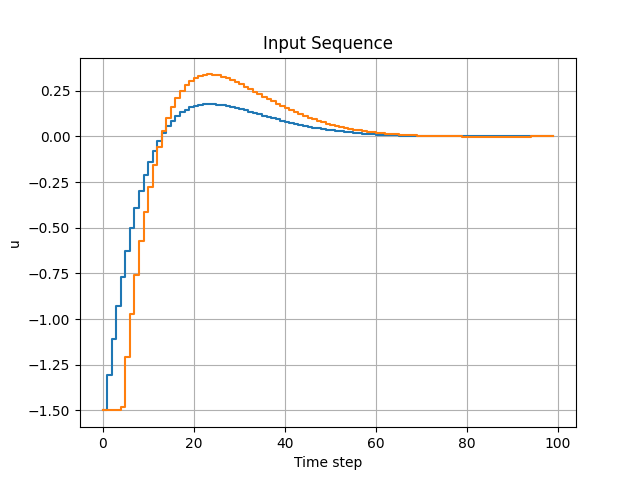

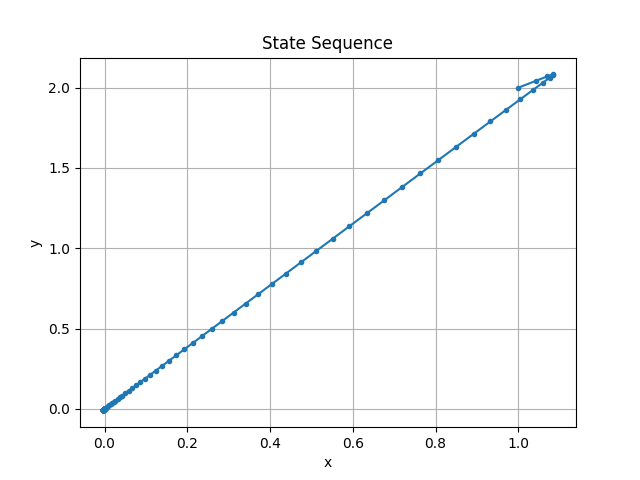

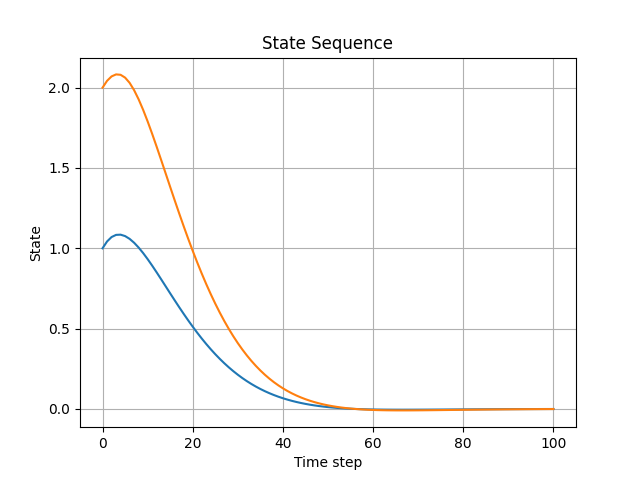

In [10]:
%matplotlib ipympl
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x_bar_sp[:, 0], x_bar_sp[:, 1], 'o-', markersize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Sequence')
plt.grid()

plt.figure()
plt.plot(range(N + 1), x_bar_sp[:, 0], label='x')
plt.plot(range(N + 1), x_bar_sp[:, 1], label='y')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('State Sequence')
plt.grid()

plt.figure()
plt.step(range(N), u_bar_sp[:, 0], label='u1')
plt.step(range(N), u_bar_sp[:, 1], label='u2')
plt.xlabel('Time step')
plt.ylabel('u')
plt.title('Input Sequence')
plt.grid()

plt.show()

## Closed-loop Trajectory

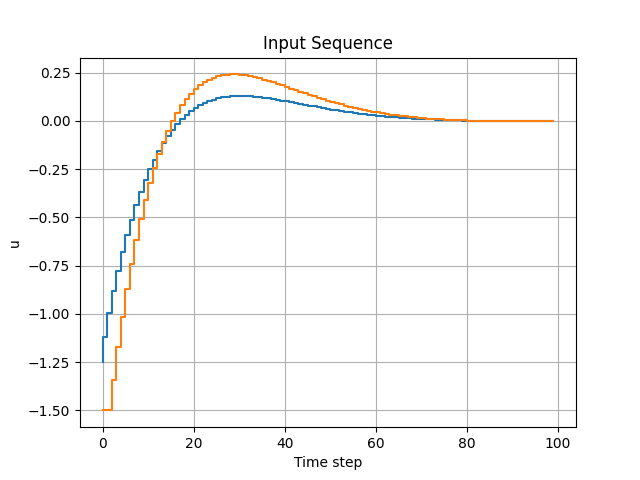

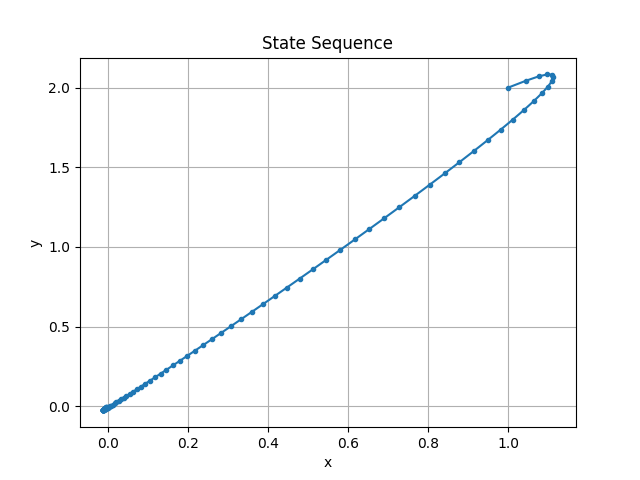

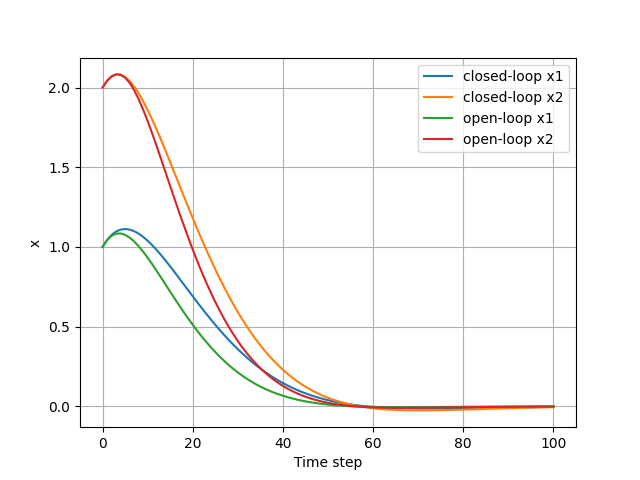

In [11]:
N = 15
Q = np.eye(dim_x)
R = np.eye(dim_u)
P = np.eye(dim_x)
x0 = np.array([1, 2, 0.5, 0.5])
# x0 = np.array([2., 1., 0., 0.])

N_sim = 100
x_hist = np.zeros((N_sim + 1, dim_x))
u_hist = np.zeros((N_sim, dim_u))
x_hist[0, :] = x0

for t in range(N_sim): 
    # print(f"Time step: {t}")
    x_bar, u_bar = solve_mpc_condensed(Ad, Bd, Q, R, P, x_hist[t, :], N, u_lb, u_ub)
    u0 = u_bar[0, :] # Take the first control input
    u_hist[t, :] = u0
    x_hist[t + 1, :] = Ad @ x_hist[t, :] + Bd @ u0 # Forward simulation


plt.figure()
plt.plot(x_hist[:, 0], x_hist[:, 1], 'o-', markersize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Sequence')
plt.grid()

plt.figure()
plt.plot(range(N_sim + 1), x_hist[:, 0], label='closed-loop x1')
plt.plot(range(N_sim + 1), x_hist[:, 1], label='closed-loop x2')

plt.plot(range(N_sim + 1), x_bar_sp[:, 0], label='open-loop x1')
plt.plot(range(N_sim + 1), x_bar_sp[:, 1], label='open-loop x2')

plt.legend()
plt.xlabel('Time step')
plt.ylabel('x')
plt.grid()

plt.figure()
plt.step(range(N_sim), u_hist[:, 0], label='u1')
plt.step(range(N_sim), u_hist[:, 1], label='u2')
plt.xlabel('Time step')
plt.ylabel('u')
plt.title('Input Sequence')
plt.grid()

plt.show()

# What's next?
- The function of the terminal cost

- Other missing ingredients in the current MPC formulation
  
  - State constraints
  
  - Terminal set

- Sparse v.s. Condensed
  